In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from user_defined_functions import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

In [2]:
description = {'loan_amnt': """The listed amount of the loan applied for by the borrower. 
                            If at some point in time,  the credit department reduces the loan amount, 
                            then it will be reflected in this value.""",
               'funded_amnt': "The total amount committed to that loan at that point in time.",
               'term': "The number of payments on the loan. Values are in months and can be either 36 or 60.",
               'int_rate': "Interest Rate on the loan",
               'grade': "LC assigned loan grade",
               'annual_inc': "The self-reported annual income provided by the borrower during registration.",
               'issue_d': "The month which the loan was funded",
               'dti': """A ratio calculated using the borrower’s total monthly debt payments on the total 
                      debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s 
                      self-reported monthly income.""",
               'revol_bal': "Total credit revolving balance",
               'total_pymnt': "Payments received to date for total amount funded",
               'loan_status': "Current status of the loan"}

# 1. Data Exploration

## 1.1 Read data

In [3]:
relevant_columns = ['loan_amnt', 'funded_amnt', 'term', 'int_rate', 
                    'grade', 'annual_inc', 'issue_d', 'dti', 
                    'revol_bal', 'total_pymnt', 'loan_status']

In [4]:
loan_data = pd.read_csv('loan.csv', usecols=relevant_columns)

## 1.2 Inspect the whole dataset

For this exercise, we will be using 11 columns. There are 2.2M samples in the dataset and there is no duplicates.

In [5]:
loan_data.shape
loan_data.head()

(2260668, 11)

,loan_amnt,funded_amnt,term,int_rate,grade,annual_inc,issue_d,loan_status,dti,revol_bal,total_pymnt
0,2500,2500,36 months,13.56,C,55000.0,Dec-2018,Current,18.24,4341,167.02
1,30000,30000,60 months,18.94,D,90000.0,Dec-2018,Current,26.52,12315,1507.11
2,5000,5000,36 months,17.97,D,59280.0,Dec-2018,Current,10.51,4599,353.89
3,4000,4000,36 months,18.94,D,92000.0,Dec-2018,Current,16.74,5468,286.71
4,30000,30000,60 months,16.14,C,57250.0,Dec-2018,Current,26.35,829,1423.21


In [6]:
loan_data.drop_duplicates().shape

(2260668, 11)

In [7]:
loan_data.describe()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt
count,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260668e+06,2.260668e+06
mean,1.504693e+04,1.504166e+04,1.309291e+01,7.799243e+04,1.882420e+01,1.665846e+04,1.182403e+04
std,9.190245e+03,9.188413e+03,4.832114e+00,1.126962e+05,1.418333e+01,2.294831e+04,9.889599e+03
min,5.000000e+02,5.000000e+02,5.310000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+03,8.000000e+03,9.490000e+00,4.600000e+04,1.189000e+01,5.950000e+03,4.272580e+03
50%,1.290000e+04,1.287500e+04,1.262000e+01,6.500000e+04,1.784000e+01,1.132400e+04,9.060870e+03
75%,2.000000e+04,2.000000e+04,1.599000e+01,9.300000e+04,2.449000e+01,2.024600e+04,1.670797e+04
max,4.000000e+04,4.000000e+04,3.099000e+01,1.100000e+08,9.990000e+02,2.904836e+06,6.329688e+04


Get info on missing data. Most columns have no missing values except for **dti** and **annual_inc**.

In [8]:
# check if there are missing values
def get_missing_info(df):
    """
    df: pandas dataframe

    return: dataframe of count and percentage of missing value for
            each column in the input dataframe
    """
    missing_ct = pd.DataFrame(df.isnull().sum()).reset_index().rename(columns={'index': 'Feature Name', 0: 'Count'})
    missing_ct['Percentage'] = (missing_ct['Count'] / len(df)) * 100
    return missing_ct.sort_values('Count', ascending=False)

In [9]:
get_missing_info(loan_data)

,Feature Name,Count,Percentage
8,dti,1711,0.075686
5,annual_inc,4,0.000177
0,loan_amnt,0,0.000000
1,funded_amnt,0,0.000000
2,term,0,0.000000
3,int_rate,0,0.000000
4,grade,0,0.000000
6,issue_d,0,0.000000
7,loan_status,0,0.000000
9,revol_bal,0,0.000000


## 1.3 Data exploration by variable

### 1.3.1 Loan amount & funded amount

* The left plot shows the distribution of loan amount
* The right plot shows the distribution of funded amount
* There doesn't seem to be outliers in both variables
* The distributions of the two variables are very similar

/Users/jinxin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


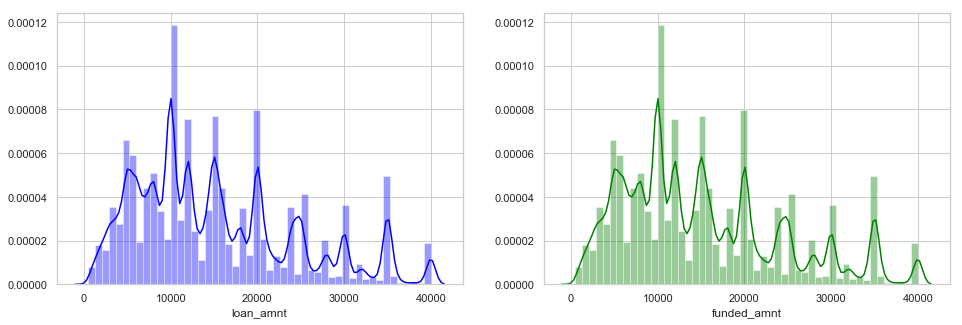

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(16,5));
sns.distplot(loan_data['loan_amnt'], ax=ax[0], color='blue');
sns.distplot(loan_data['funded_amnt'], ax=ax[1], color='green');

The scatter plot of funded amount vs. loan amount shows most of loans are fully funded and there are some that are funded partially.

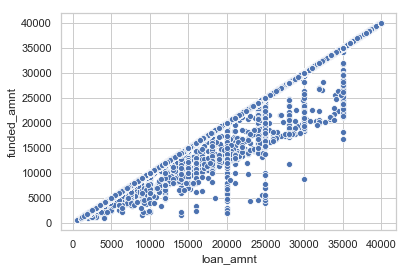

In [11]:
sns.scatterplot(x='loan_amnt', y='funded_amnt', data=loan_data);

### 1.3.2 Loan by year of origination

The plot belows shows the number of loans by year of origination. 2015-2018 have the most loans applied by borrowers.

In [12]:
loan_data['issue_d'] = pd.to_datetime(loan_data['issue_d'])
loan_data['year_of_origination'] = loan_data['issue_d'].dt.year

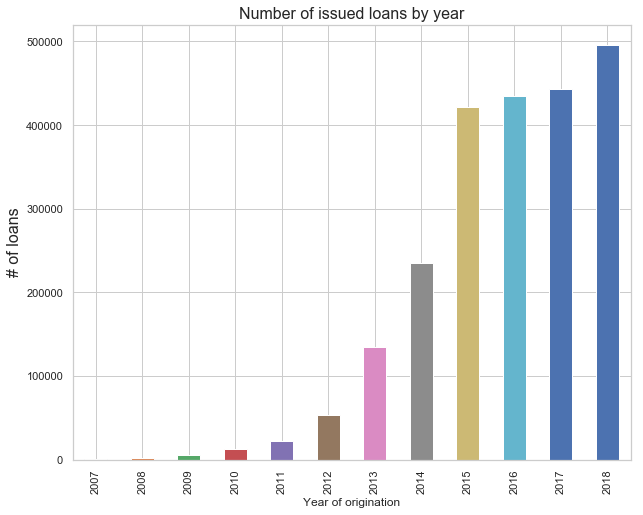

In [13]:
plt.figure(figsize=(10,8))
loan_data.groupby('year_of_origination')['loan_amnt'].count().plot(kind='bar')
plt.title('Number of issued loans by year', fontsize=16);
plt.xlabel('Year of origination');
plt.ylabel('# of loans', fontsize=16);

The plot below shows the average loan amount by year. 2018 on average has the highest loan applied by borrowers, followed by 2014.

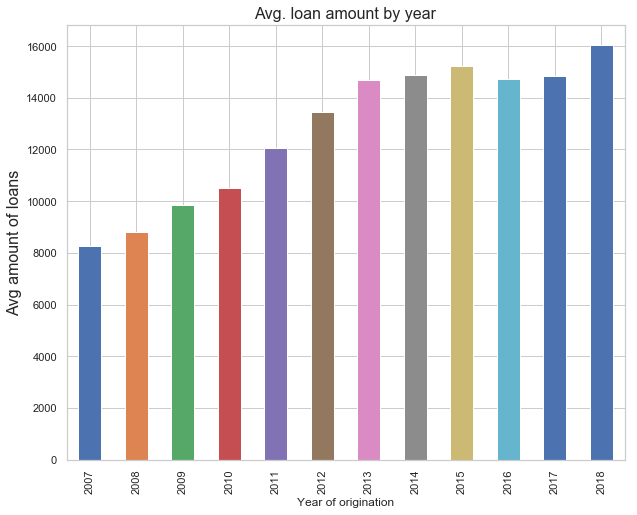

In [14]:
plt.figure(figsize=(10,8))
loan_data.groupby('year_of_origination')['loan_amnt'].mean().plot(kind='bar')
plt.title('Avg. loan amount by year', fontsize=16);
plt.xlabel('Year of origination');
plt.ylabel('Avg amount of loans', fontsize=16);

### 1.3.3 Loan amount by loan status

For this exercise, we will treat any loans that are not **fully paid** as **defaulted**.

The violin plot below shows that:
* Overall, the distribution of loan amount is not significantly different between "Fully Paid" and "Defaulted" loans
* When taking a closer look, fully paid loans concentrate more on smaller amount (below 10k) then defaulted loans
* Defaulted loans in general have larger amount, especially around 40k

In [15]:
loan_data['loan_status_new'] = loan_data['loan_status'].apply(lambda value: "Fully Paid" if value == 'Fully Paid'
                                                             else "Defaulted")

/Users/jinxin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


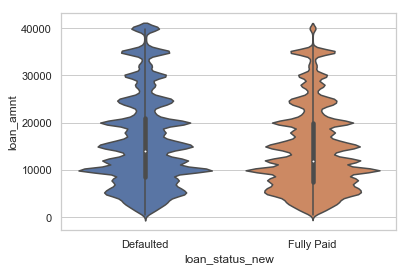

In [16]:
sns.violinplot(x="loan_status_new", y="loan_amnt", data=loan_data);

### 1.3.4 Loan amount by income group

Based on the 20th and 80th percentiles of annual income, we will break income into 3 groups:
* High income group: annual income >= 100000
* Medium income group: 42000 <= annual income < 100000
* Low income group: annual income < 42000


**Summary:**
1. From the violin plot below, we can see that low income group tend to borrow small loans and people with high (>= 100k) income tend to borrow larger loans.
2. From the boxplot below, it's clear that the median loan amount differs among the income groups. We also include a category where income is missing. There are 4 samples where income is missing. In the modeling section, we will use the median of income to impute the missing values so we can avoid the effect of outliers.
3. The 99.9th percentile of income is 600k but the max is 110M. Though it's possible that a person who makes 110M per year borrows from Lending Club, this chance is small. It could be that the currency is different, more info on the currency would be helpful. For this exercise, we can cap the income at 600k.

In [17]:
loan_data['annual_inc'].describe(percentiles=list(np.arange(0, 1, 0.1)) + [0.95, 0.999])

count    2.260664e+06
mean     7.799243e+04
std      1.126962e+05
min      0.000000e+00
0%       0.000000e+00
10%      3.400000e+04
20%      4.200000e+04
30.0%    5.000000e+04
40%      5.800000e+04
50%      6.500000e+04
60.0%    7.500000e+04
70%      8.500000e+04
80%      1.000000e+05
90%      1.300000e+05
95%      1.600000e+05
99.9%    6.000000e+05
max      1.100000e+08
Name: annual_inc, dtype: float64

In [18]:
loan_data['annual_inc'] = loan_data['annual_inc'].apply(lambda value: 6e5 if value >= 6e5 else value)

In [19]:
def income_group(value):
    if value < 42000:
        return "Low"
    elif 42000 <= value < 100000:
        return "Medium"
    elif value >= 100000:
        return "High"
    else:
        return "Missing"

In [20]:
loan_data['income_group'] = loan_data['annual_inc'].apply(income_group)

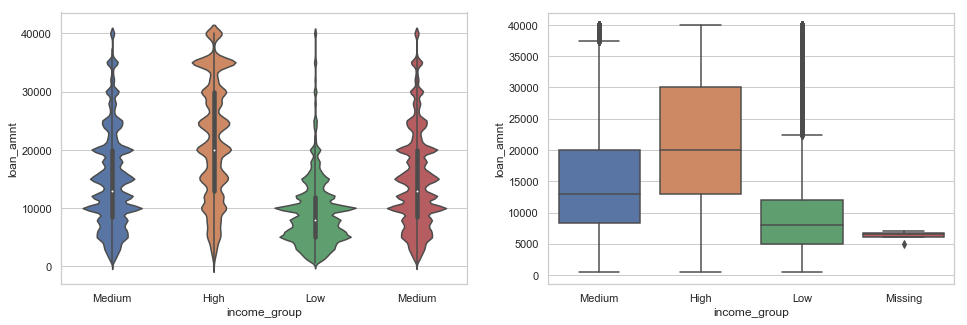

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))
sns.violinplot(x="income_group", y="loan_amnt", ax=ax[0], data=loan_data.dropna(subset=['annual_inc']));
sns.boxplot(x="income_group", y="loan_amnt", ax=ax[1], data=loan_data)

### 1.3.5 Loan status by grade

The two stacked bar plots show the percentage and count of defaulted loans vs. fully paid loans by grade.

* There is smaller number of loans belong to Grade G, however, it has the highest default rate - 63.27%
* Grade A and Grade B loans have a little over 50% default rate
* Note that, we treat loan with **Current** status as default, this might inflate the default rate

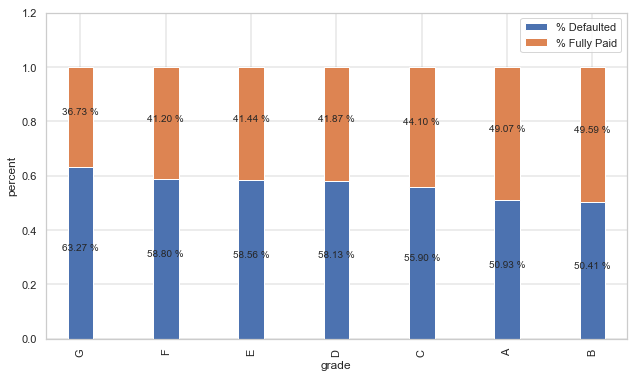

In [22]:
stacked_barplot(loan_data, response_var='loan_status_new', feature_name='grade', 
                plot_type='percent', top_n_category=10)

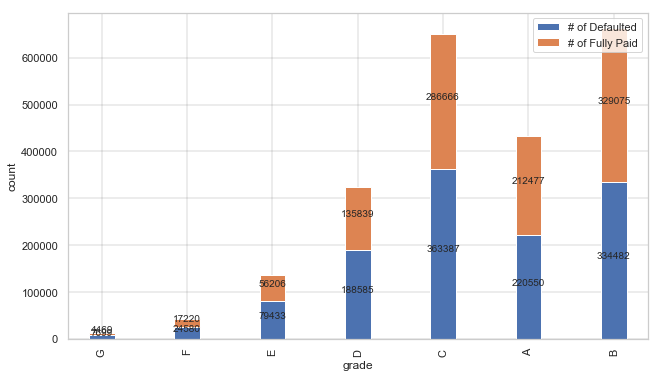

In [23]:
stacked_barplot(loan_data, response_var='loan_status_new', feature_name='grade', 
                plot_type='count', top_n_category=10)

### 1.3.6 Loan status by term

The two stacked bar plots show the percentage and count of defaulted loans vs. fully paid loans by term.

* Loans with a term of 60 months have a default rate of 67%. This is significantly higher than 48% of the 36-month termed loans
* Note again, we treat loans with **Current** status as default, this might inflate the default rate. Especially when loans with a term of 60 months happened after 2014 are not due yet.

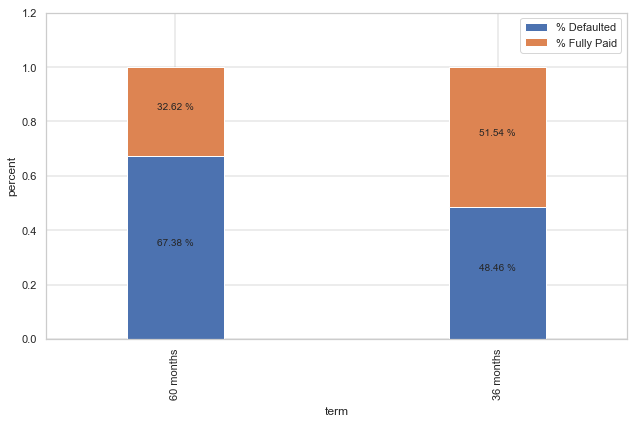

In [24]:
stacked_barplot(loan_data, response_var='loan_status_new', feature_name='term', plot_type='percent')

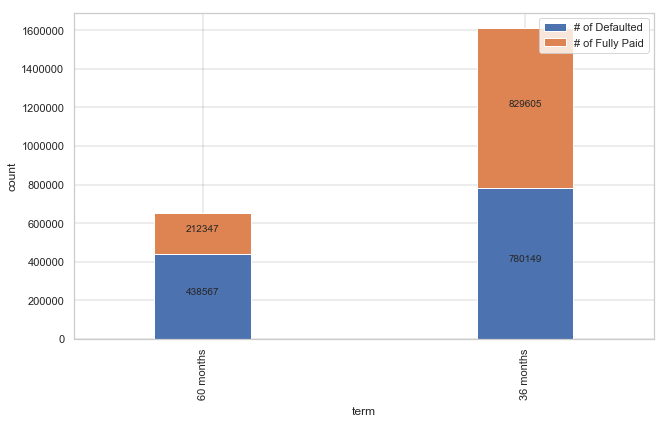

In [25]:
stacked_barplot(loan_data, response_var='loan_status_new', feature_name='term', plot_type='count')

### 1.3.7 Loan status by year of origination

* Before 2015, the % of fully paid loans is significantly higher than subsequent years
* After 2015, more loans are defaulted. This could be skewed by our assumption that "Current" loans are treated as defaulted.

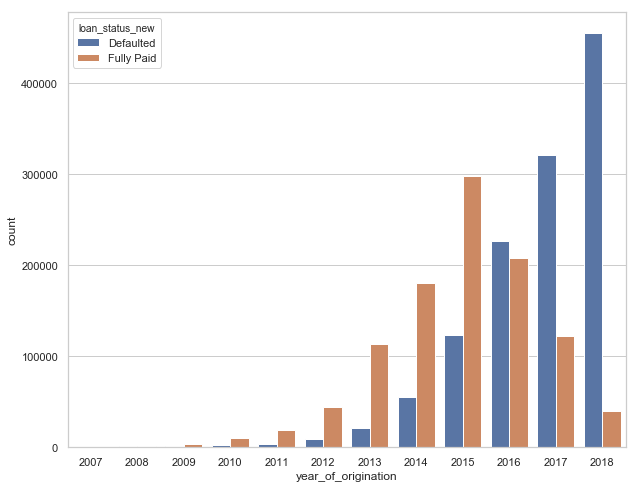

In [26]:
fig, ax = plt.subplots(figsize=[10, 8])
sns.countplot(x='year_of_origination', hue='loan_status_new', data=loan_data, ax=ax)

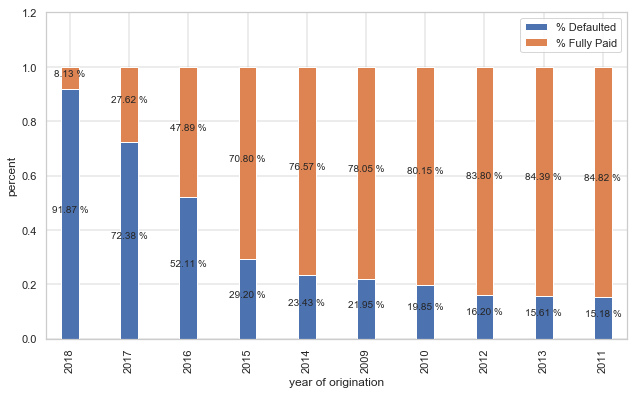

In [27]:
stacked_barplot(loan_data, response_var='loan_status_new', feature_name='year_of_origination', 
                plot_type='percent', top_n_category=10)

### 1.3.8 Interest rate by loan status

* The trend of interest rate between defaulted loans and fully paid loans are similar with 2013 having the highest interest rate
* Since 2008, the avg. interest rate has been above 11%

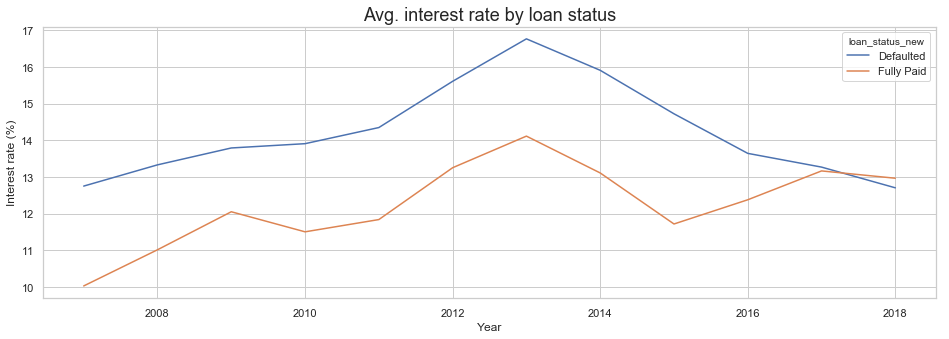

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16,5));
int_rate_loan_status = loan_data.groupby(['year_of_origination', 'loan_status_new'])['int_rate'].mean()
int_rate_loan_status.unstack().plot(ax=ax)
ax.set_title('Avg. interest rate by loan status', fontsize=18);
ax.set_xlabel('Year');
ax.set_ylabel('Interest rate (%)');

### 1.3.9 Debt-to-income ratio

* The left plot is a boxplot of DTI by loan status without outliers
* The right plot is a boxplot of DTI by loan status with outliers
* When looking at the left plot, there is no significant distributional different in DTI between defaulted loans and fully paid loans
* When looking at the right plot, the number of outliers is large in both groups
* The DTI is capped at 999 which seems to be a choice made by Lending Club

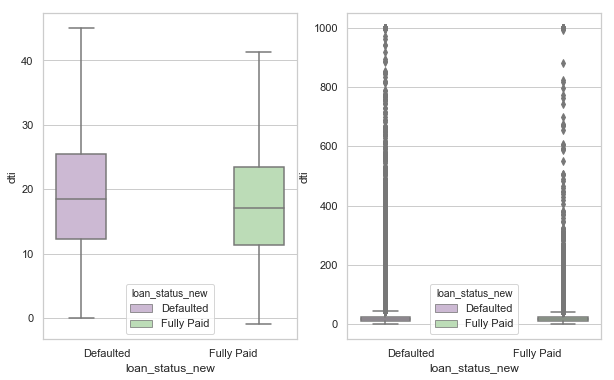

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 6))
s = sns.boxplot(ax = ax1, x="loan_status_new", y="dti", hue="loan_status_new",
                data=loan_data, palette="PRGn",showfliers=False)
s = sns.boxplot(ax = ax2, x="loan_status_new", y="dti", hue="loan_status_new",
                data=loan_data, palette="PRGn",showfliers=True)

### 1.3.10 Total payment & funded amount

We can compute the ratio of total payment over funded amount. The ratio indicates how much loan has already been paid off.

* It's no surprise that full paid loans have a higher PTF based on the boxplots
* The time series plot shows that over the year fully paid loans on average have created about 10-20% margin for lending club (indicated by 1.1~1.2 PTF)
* The PTF for defaulted loans is around 60-80% with the exception of 2018 when most loans are still new

In [30]:
loan_data['ptf'] = loan_data['total_pymnt'] / loan_data['funded_amnt']

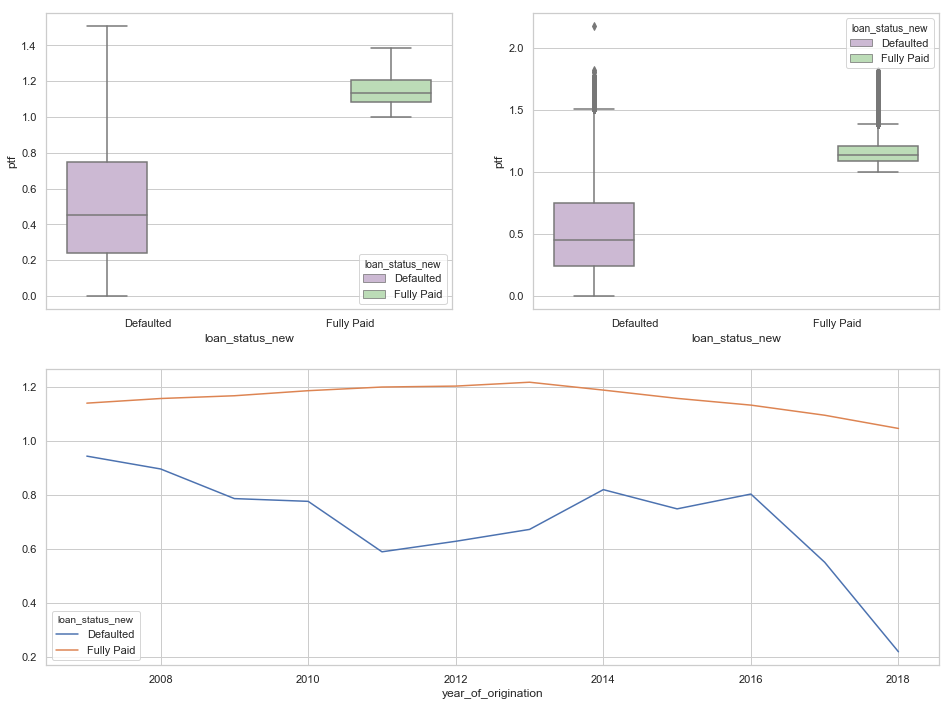

In [31]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)
s = sns.boxplot(ax = ax1, x="loan_status_new", y="ptf", hue="loan_status_new",
                data=loan_data, palette="PRGn",showfliers=False)
s = sns.boxplot(ax = ax2, x="loan_status_new", y="ptf", hue="loan_status_new",
                data=loan_data, palette="PRGn",showfliers=True)
int_rate_loan_status = loan_data.groupby(['year_of_origination', 'loan_status_new'])['ptf'].mean()
int_rate_loan_status.unstack().plot(ax=ax3)

### 1.3.11 Revolving balance

* The avg. credit revolving balance has been similar between defaulted and fully paid loans after 2011
* The difference is huge (~13k) for the 2009 cohort

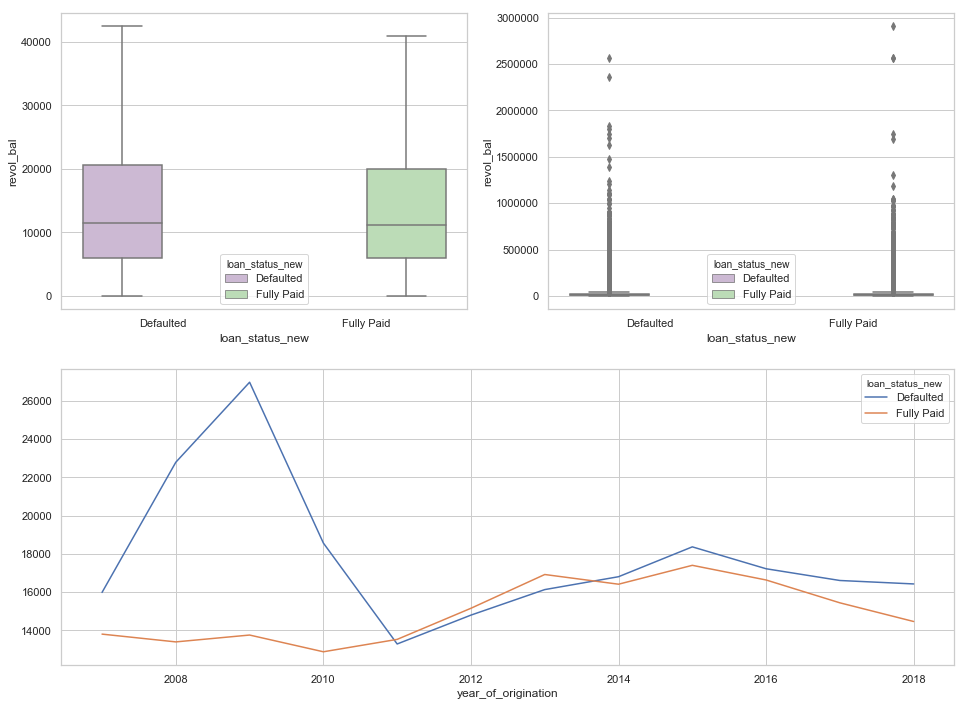

In [32]:
fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)
s = sns.boxplot(ax = ax1, x="loan_status_new", y="revol_bal", hue="loan_status_new",
                data=loan_data, palette="PRGn",showfliers=False)
s = sns.boxplot(ax = ax2, x="loan_status_new", y="revol_bal", hue="loan_status_new",
                data=loan_data, palette="PRGn",showfliers=True)
int_rate_loan_status = loan_data.groupby(['year_of_origination', 'loan_status_new'])['revol_bal'].mean()
int_rate_loan_status.unstack().plot(ax=ax3)

### 1.3.11 Correlation heatmap

The heatmap shows:
1. funded amount and loan amount are highly correlated. For modeling, we probably only need funded amount as that's what borrowers need to pay off
2. Total payment has a correlation coefficient of 0.65 with funded amount.

In [33]:
def corr_mat_heatmap(df):
    """
    df: pandas dataframe
    this function plots a correlation matrix heatmap based on the input dataframe
    """
    corr_matrix = df.corr()

    sns.set(style='white', font_scale=1.4)
    f, ax = plt.subplots(figsize=(14, 9))

    # Create a mask for the upper triangle
    mask = np.zeros_like(corr_matrix, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = sns.diverging_palette(300, 50, as_cmap=True)
    sns.heatmap(corr_matrix, cmap=cmap, mask=mask, 
                annot=True, annot_kws={'size': 12})
    ax.set_title('Correlation Matrix Heatmap')

In [34]:
loan_data_clean = loan_data[['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc',
                             'dti', 'revol_bal', 'total_pymnt', 'ptf']]

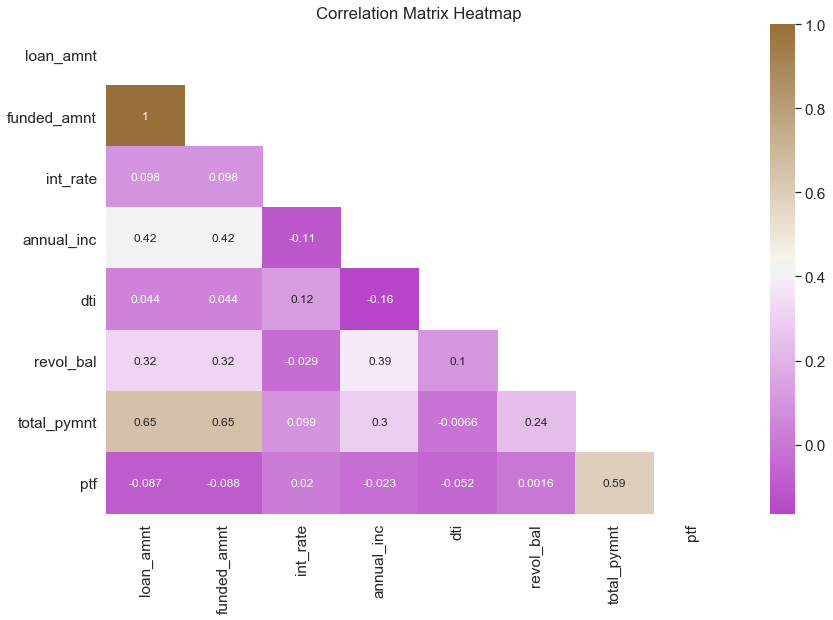

In [35]:
corr_mat_heatmap(loan_data_clean)

# 2. Business Analytics

## 2.1 What percentage of loans has been fully paid?

If our goal is to evaluate whether the 36-month term loans would make for a good investment. We should probably remove loans with either less or more than 36 month term. As shown in the bar plot below, the rate of default differs by almost 20% between 36-month and 60-month term loans. Therefore, I made the decision to remove loans with a 60-month term. This action will remove 650k samples from our dataset. In actual work, I'd consult with the product owner before making this decision.

Answer: 51.54% of 36-month term loans are fully paid.

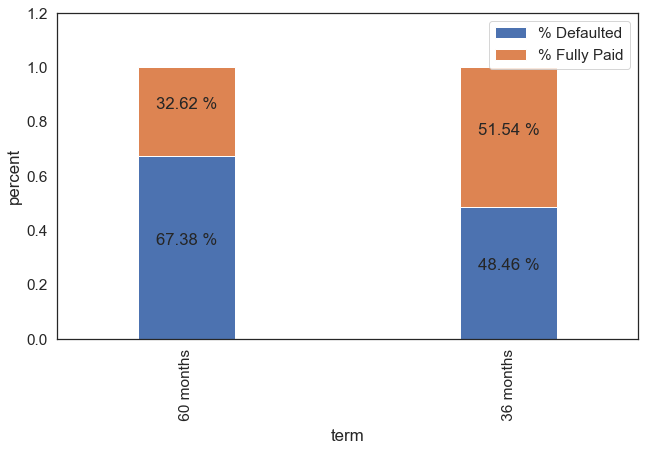

In [36]:
stacked_barplot(loan_data, response_var='loan_status_new', feature_name='term', 
                plot_type='percent', top_n_category=10)

In [37]:
loan_data_reduce = loan_data[loan_data['term'] == ' 36 months'].reset_index(drop=True)

## 2.2 When bucketed by year of origination and grade, which cohort has the highest rate of defaults? Here you may assume that any loan which was not fully paid had “defaulted”.

* 2007 Grade G loans have the highest rate of defaults
* The high default rate in 2018 is likely due to our assumption that any loan which hasn't been fully paid is "defaulted"

In [38]:
loan_data_reduce['binary_loan_status'] = loan_data_reduce['loan_status_new'].\
                                         apply(lambda value: 1 if value == 'Defaulted' else 0)
loan_default_percentage = loan_data_reduce.groupby(['year_of_origination', 'grade'])['binary_loan_status'].mean()

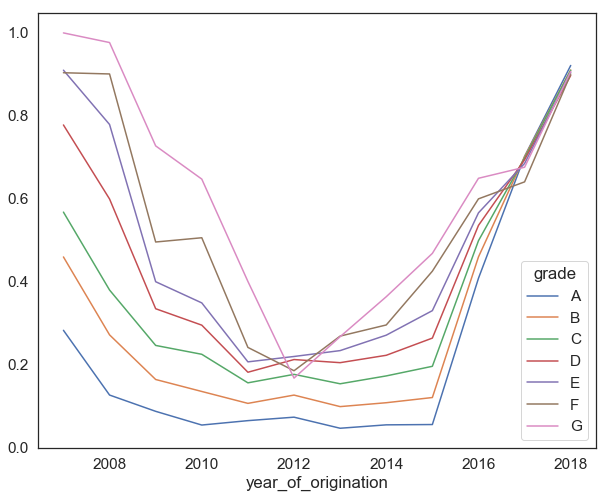

In [39]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
loan_default_percentage.unstack().plot(ax=ax)

In [40]:
loan_default_percentage.reset_index().sort_values('binary_loan_status', ascending=False).head()

,year_of_origination,grade,binary_loan_status
6,2007,G,1.000000
13,2008,G,0.976744
77,2018,A,0.921390
78,2018,B,0.910363
4,2007,E,0.910000


## 2.3 When bucketed by year of origination and grade, what annualized rate of return have these loans generated on average?

* The rate of return is slightly above 0% before 2017 for grade A-F. Grade G loans have mostly negative rate of return across the years, indicating high risk.
* In 2017 and 2018, the rate of return has significantly dropped likely due to many loans are still being paid off.

In [41]:
loan_data_reduce['rate_of_return'] = (loan_data_reduce['total_pymnt'] / loan_data_reduce['funded_amnt'])**(1/3) - 1

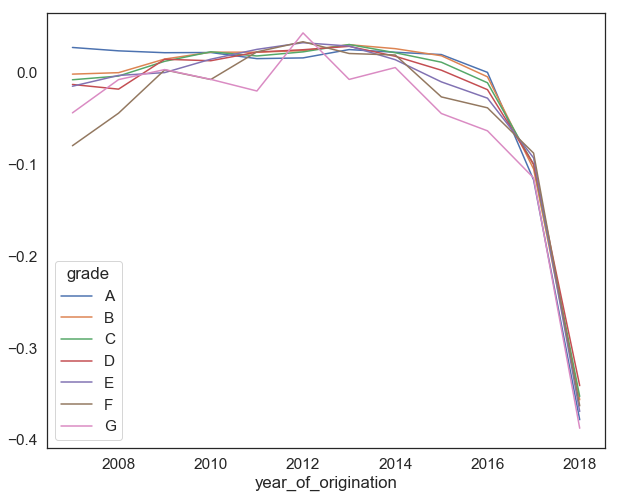

In [42]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
return_rate = loan_data_reduce.groupby(['year_of_origination', 'grade'])['rate_of_return'].mean()
return_rate.unstack().plot(ax=ax)

In [43]:
return_rate.reset_index().head(10)

,year_of_origination,grade,rate_of_return
0,2007,A,0.027156
1,2007,B,-0.001857
2,2007,C,-0.008002
3,2007,D,-0.013119
4,2007,E,-0.015043
5,2007,F,-0.079793
6,2007,G,-0.044028
7,2008,A,0.023488
8,2008,B,-0.000276
9,2008,C,-0.003972


In [44]:
return_rate.reset_index()['rate_of_return'].describe()

count    84.000000
mean     -0.034810
std       0.106594
min      -0.387364
25%      -0.027000
50%       0.002581
75%       0.021742
max       0.043012
Name: rate_of_return, dtype: float64

# 3. Modeling

We want to consider the fact that loan default might behave differently across years. To build a high-quality model, it's important to set up a robust validation framework. For this exercise we will do the following:

* Split the data into training (data through 2017) and test (data of 2018)
* For the training data, apply a fixed start incremental window validation strategy:
    * Train model on data of 2007-2014 and validate on 2015
    * Train model on data of 2007-2015 and validate on 2016
    * Train model on data of 2007-2016 and validate on 2017
* To evaluate the model, we will look at the weighted avg. precision, recall, and F1-score across the validation sets
* Once we are satisfied with the model performance, train a model on data of 2007-2017 and make predictions on 2018 data.

As for features, we will remove the following:
* issue_d
* loan_amount: it's highly correlated with funded amount which is what borrowers eventually get from Lending Club
* term: we will only focus on 36-month term loans

In [45]:
drop_vars = ['loan_amnt', 'issue_d', 'term', 'loan_status', 'loan_status_new']
loan_data_reduce = loan_data_reduce.drop(drop_vars, axis=1)

Convert categorical variables into dummy variables:

In [46]:
loan_data_dummies = pd.get_dummies(loan_data_reduce[['grade', 'income_group']])
loan_data_final = pd.concat([loan_data_reduce, loan_data_dummies], axis=1)
loan_data_final = loan_data_final.drop(['grade', 'income_group'], axis=1)

Fill missing values with column median:

In [47]:
dti_median = loan_data_final['dti'].median()
loan_data_final['dti'] = loan_data_final['dti'].fillna(dti_median)
inc_median = loan_data_final['annual_inc'].median()
loan_data_final['annual_inc'] = loan_data_final['annual_inc'].fillna(inc_median)

## 3.1 Time series cross validation

In [48]:
precision_list = []
recall_list = []
f1_score_list = []
for year in [2015, 2016, 2017]:
    train = loan_data_final[loan_data_final['year_of_origination'] < year].reset_index(drop=True)
    test = loan_data_final[loan_data_final['year_of_origination'] == year].reset_index(drop=True)
    X_train, y_train = train.drop(['binary_loan_status', 'year_of_origination'], axis=1), train['binary_loan_status']
    X_test, y_test = test.drop(['binary_loan_status', 'year_of_origination'], axis=1), test['binary_loan_status']
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, average='binary')
    precision_list.append(precision)
    recall_list.append(recall)
    f1_score_list.append(f1_score)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

**Summary**

* Precision: The model is capturing default loans with high precision - out of all defaulted loans, the model predicts 98.9% of them correctly
* Recall: the recall is a bit low as compared to precision. After inspection, it turns the 2016 validation set only has a recall of 0.52.
* F1 score: across 2015-2017, the F1 score is pretty reasonable at 0.85
* Based on the validation performance, the model is effective but needs improvement on recall

In [49]:
print("Avg. precision across validation sets: ", np.mean(precision_list))
print("Avg. recall across validation sets: ", np.mean(recall_list))
print("Avg. f1 score across validation sets: ", np.mean(f1_score_list))

Avg. precision across validation sets:  0.9877280043487614
Avg. recall across validation sets:  0.7781161412451761
Avg. f1 score across validation sets:  0.8561829934381344


In [50]:
recall_list

[0.8385101963746223, 0.5186310644081974, 0.9772071629527085]

## 3.2 Prediction

**Summary**

The model has an almost perfect precision and recall on the 2018 data. However, it should be noted, the data is highly skewed toward the default class - 90% of the 2018 data belong to the default class. As mentioned before, this is likely due to us assuming "current" loan as "default" which is probably not valid for loans of recent years.

In [51]:
train = loan_data_final[loan_data_final['year_of_origination'] < 2018].reset_index(drop=True)
test = loan_data_final[loan_data_final['year_of_origination'] == 2018].reset_index(drop=True)
X_train, y_train = train.drop(['binary_loan_status', 'year_of_origination'], axis=1), train['binary_loan_status']
X_test, y_test = test.drop(['binary_loan_status', 'year_of_origination'], axis=1), test['binary_loan_status']
model = LogisticRegression(solver='lbfgs')
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [52]:
y_pred_2018 = model.predict(X_test)

In [53]:
print(classification_report(y_test, y_pred_2018))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     30105
           1       0.99      1.00      0.99    314566

   micro avg       0.99      0.99      0.99    344671
   macro avg       0.97      0.94      0.95    344671
weighted avg       0.99      0.99      0.99    344671



Confusion matrix, without normalization
[[ 26669   3436]
 [  1377 313189]]


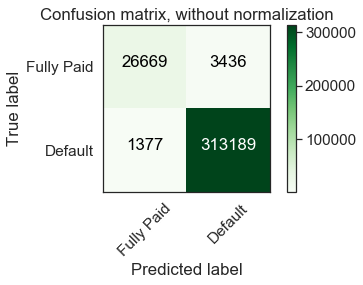

In [54]:
cnf_matrix = confusion_matrix(y_test, y_pred_2018)
plot_confusion_matrix(cnf_matrix, classes=['Fully Paid', 'Default'],
                      title='Confusion matrix, without normalization')

# 4. Next steps

* For the data quality part, we should understand better why there are outliers in income, is it due to inconsistent currency unit?
* Throughout the exercise, we assume any current loans as defaulted. This assumption is flawed as we don't have enough information on loans of more recent years. This assumption causes the distribution of data to be differnt between recent years and previous years. e.g., rate of return. To be conservative, it'd be reasonable to have a more strict definition of defaulted loans
* For the business analysis and modeling part, I removed 60-month term loans. This drops 650k samples from the dataset. Whether this is the right interpretation of the question merits more context and information.
* For modeling, it'd be reasonable to look at years with low precison/recall (e.g., 2016) and understand the reasons behind.
* More feature engineering on the existing variables.
* More EDA on other variables outside of the requirements of this exercise.